In [1]:
#Importing libraries
import time
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

#sklearn imports
#tools
from sklearn.preprocessing import scale, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

#models
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

In [2]:
#import datasets
data = pd.read_csv('../data/processed/data_technicals.csv', index_col = 0)
data_zscore = pd.read_csv('../data/processed/data_zscore_technicals.csv', index_col = 0)
daily_moves = pd.read_csv('../data/processed/daily_moves_technical.csv', index_col = 0)

data.head()

,close_mean,close_std,close_max,close_min,close_max-min,close_up_down,volume,volume_pct_change,volume_up_down,mfi_label,roc_labels,stochastic_label,rsi_label,macd_labels
2011-08-20,0.000059,0.002254,0.085543,0.000000,0.085543,1.0,0.085470,0.000000,0.0,between_2080,below_0_decreasing,between_2080,between_3070,below_0_decreasing
2011-08-21,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.085470,0.000000,0.0,between_2080,below_0_decreasing,between_2080,between_3070,below_0_decreasing
2011-08-22,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.028632,-66.499988,0.0,between_2080,below_0_decreasing,between_2080,between_3070,below_0_decreasing
2011-08-23,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,-100.000000,0.0,between_2080,below_0_decreasing,between_2080,between_3070,below_0_decreasing
2011-08-24,-0.007386,0.158258,0.000000,-4.347826,4.347826,0.0,2.356522,inf,1.0,between_2080,below_0_decreasing,between_2080,between_3070,below_0_decreasing


<h2>Encoding technical indicators categorical features</h2> 

In [3]:
encoder = OneHotEncoder(handle_unknown = 'error', drop='first')
X_to_encode = data[['mfi_label', 'roc_labels', 'stochastic_label', 'rsi_label', 'macd_labels']]
encoder.fit(X_to_encode)

OneHotEncoder(drop='first')

In [4]:
encoder.categories_

[array(['above_80', 'below_20', 'between_2080'], dtype=object),
 array(['above_0_decreasing', 'above_0_increasing', 'below_0_decreasing',
        'below_0_increasing'], dtype=object),
 array(['above_80', 'below_20', 'between_2080'], dtype=object),
 array(['above_70', 'below_30', 'between_3070'], dtype=object),
 array(['above_0_decreasing', 'above_0_increasing', 'below_0_decreasing',
        'below_0_increasing'], dtype=object)]

In [5]:
encoder_columns = list(encoder.get_feature_names(['mfi', 'roc', 'stochastic', 'rsi', 'macd']))
encoder_columns

['mfi_below_20',
 'mfi_between_2080',
 'roc_above_0_increasing',
 'roc_below_0_decreasing',
 'roc_below_0_increasing',
 'stochastic_below_20',
 'stochastic_between_2080',
 'rsi_below_30',
 'rsi_between_3070',
 'macd_above_0_increasing',
 'macd_below_0_decreasing',
 'macd_below_0_increasing']

In [6]:
technicals_encoded = encoder.transform(X_to_encode).toarray()
technicals_encoded


array([[0., 1., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       ...,
       [0., 1., 1., ..., 1., 0., 0.],
       [0., 1., 1., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

<h2>Scaling numeric data from the 3 datasets</h2> 

In [7]:
#Making DataFrames numeric columns
data_numeric = data[['close_mean', 'close_std', 'close_max', 'close_min', 'close_max-min', 'close_up_down',
                     'volume', 'volume_pct_change']]

zscore_numeric = data_zscore[['close_mean', 'close_std', 'close_max', 'close_min', 'close_max-min', 'close_up_down',
                              'volume', 'volume_pct_change']]

daily_moves_numeric = daily_moves[['open-close', 'open-max', 'open-min', 'min-close', 'min-max', 'max-close']]

data_numeric.head()

,close_mean,close_std,close_max,close_min,close_max-min,close_up_down,volume,volume_pct_change
2011-08-20,0.000059,0.002254,0.085543,0.000000,0.085543,1.0,0.085470,0.000000
2011-08-21,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.085470,0.000000
2011-08-22,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.028632,-66.499988
2011-08-23,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,-100.000000
2011-08-24,-0.007386,0.158258,0.000000,-4.347826,4.347826,0.0,2.356522,inf


In [8]:
data_numeric.isnull().sum()

close_mean           0
close_std            0
close_max            0
close_min            0
close_max-min        0
close_up_down        0
volume               0
volume_pct_change    0
dtype: int64

In [9]:
#replace np.inf number in volume_pct_change column with 100
data_numeric.replace(to_replace=np.inf, value=100, inplace=True)
zscore_numeric.replace(to_replace=np.inf, value=100, inplace=True)

zscore_numeric.head()

/home/julio/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


,close_mean,close_std,close_max,close_min,close_max-min,close_up_down,volume,volume_pct_change
2011-08-20,-0.001576,0.009052,0.341679,-0.001814,0.343493,0.0,0.085470,0.000000
2011-08-21,-0.001814,0.000000,-0.001814,-0.001814,0.000000,0.0,0.085470,0.000000
2011-08-22,-0.001814,0.000000,-0.001814,-0.001814,0.000000,0.0,0.028632,-66.499988
2011-08-23,-0.001814,0.000000,-0.001814,-0.001814,0.000000,0.0,0.000000,-100.000000
2011-08-24,-0.031473,0.635473,-0.001814,-17.460233,17.458419,0.0,2.356522,100.000000


In [10]:
#checking for no np.inf data
data_numeric[zscore_numeric['volume_pct_change'] == np.inf]

,close_mean,close_std,close_max,close_min,close_max-min,close_up_down,volume,volume_pct_change


In [11]:
#scaling numericthe data
scaler = StandardScaler()

scaled_data_numeric = scaler.fit_transform(data_numeric)
scaled_zscore_numeric = scaler.fit_transform(zscore_numeric)
scaled_daily_moves = scaler.fit_transform(daily_moves_numeric)

scaled_daily_moves

array([[-0.05638192, -0.36657207,  0.65909585, -0.64830446, -0.51303798,
         0.66202625],
       [-0.07397181, -0.37748739,  0.65909585, -0.66442576, -0.51995695,
         0.66202625],
       [-0.07397181, -0.37748739,  0.65909585, -0.66442576, -0.51995695,
         0.66202625],
       ...,
       [-0.33249457, -0.29923639,  0.09272623, -0.41852267, -0.25920311,
         0.15298016],
       [ 1.65217203,  0.7916444 ,  0.2675663 ,  1.28110309,  0.37824208,
         0.46941805],
       [ 0.11420729, -0.04298826,  0.27748068, -0.16225626, -0.16403125,
         0.20675045]])

In [12]:
#putting scaled numeric data and encoded technical data together.

complete_data_columns = complete_data_columns = [x for x in list(data_numeric.columns)] + [x for x in encoder_columns]

#Normal data
complete_data = pd.concat([pd.DataFrame(scaled_data_numeric), pd.DataFrame(technicals_encoded)], axis=1)
complete_data.columns = complete_data_columns
complete_data.index = data.index

complete_data.head()

,close_mean,close_std,close_max,close_min,close_max-min,close_up_down,volume,volume_pct_change,mfi_below_20,mfi_between_2080,roc_above_0_increasing,roc_below_0_decreasing,roc_below_0_increasing,stochastic_below_20,stochastic_between_2080,rsi_below_30,rsi_between_3070,macd_above_0_increasing,macd_below_0_decreasing,macd_below_0_increasing
2011-08-20,-0.093640,-0.832137,-0.278977,0.535118,-0.381491,0.868355,-0.954958,-0.064916,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2011-08-21,-0.107805,-0.843981,-0.295388,0.535118,-0.392874,-1.151603,-0.954958,-0.064916,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2011-08-22,-0.107805,-0.843981,-0.295388,0.535118,-0.392874,-1.151603,-0.954964,-0.157772,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2011-08-23,-0.107805,-0.843981,-0.295388,0.535118,-0.392874,-1.151603,-0.954967,-0.204549,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2011-08-24,-1.869032,-0.012468,-0.295388,-1.111583,0.185647,-1.151603,-0.954733,0.074716,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [13]:
#zscore data
complete_zscore_data = pd.concat([pd.DataFrame(scaled_zscore_numeric), pd.DataFrame(technicals_encoded)], axis=1)
complete_zscore_data.columns = complete_data_columns
complete_zscore_data.index = data.index

complete_zscore_data.head()

,close_mean,close_std,close_max,close_min,close_max-min,close_up_down,volume,volume_pct_change,mfi_below_20,mfi_between_2080,roc_above_0_increasing,roc_below_0_decreasing,roc_below_0_increasing,stochastic_below_20,stochastic_between_2080,rsi_below_30,rsi_between_3070,macd_above_0_increasing,macd_below_0_decreasing,macd_below_0_increasing
2011-08-20,-0.093640,-0.832137,-0.278977,0.535118,-0.381491,-0.880145,-0.954958,-0.064916,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2011-08-21,-0.107805,-0.843981,-0.295388,0.535118,-0.392874,-0.880145,-0.954958,-0.064916,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2011-08-22,-0.107805,-0.843981,-0.295388,0.535118,-0.392874,-0.880145,-0.954964,-0.157772,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2011-08-23,-0.107805,-0.843981,-0.295388,0.535118,-0.392874,-0.880145,-0.954967,-0.204549,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2011-08-24,-1.869032,-0.012468,-0.295388,-1.111583,0.185647,-0.880145,-0.954733,0.074716,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [14]:
#Daily moves data
complete_daily_moves = pd.concat([pd.DataFrame(scaled_daily_moves), pd.DataFrame(technicals_encoded)], axis=1)
complete_daily_moves.columns = [x for x in list(daily_moves_numeric.columns)] + [x for x in encoder_columns]
complete_daily_moves.index = daily_moves.index

complete_daily_moves.head()

,open-close,open-max,open-min,min-close,min-max,max-close,mfi_below_20,mfi_between_2080,roc_above_0_increasing,roc_below_0_decreasing,roc_below_0_increasing,stochastic_below_20,stochastic_between_2080,rsi_below_30,rsi_between_3070,macd_above_0_increasing,macd_below_0_decreasing,macd_below_0_increasing
date,,,,,,,,,,,,,,,,,,
2011-08-20,-0.056382,-0.366572,0.659096,-0.648304,-0.513038,0.662026,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2011-08-21,-0.073972,-0.377487,0.659096,-0.664426,-0.519957,0.662026,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2011-08-22,-0.073972,-0.377487,0.659096,-0.664426,-0.519957,0.662026,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2011-08-23,-0.073972,-0.377487,0.659096,-0.664426,-0.519957,0.662026,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2011-08-24,-2.182954,-0.377487,-1.637768,-0.664426,0.404417,-2.146314,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


<h2>Partition of the data</h2>

In [15]:
#Normal data
kf_data = KFold(n_splits=3, shuffle=True, random_state=123)
kf_data

KFold(n_splits=3, random_state=123, shuffle=True)

In [16]:
for train, test in kf_data.split(complete_data):
    print("TRAIN:", train, "TEST:", test)
    print(len(train), len(test))

TRAIN: [   0    1    2 ... 3470 3471 3472] TEST: [   4    5   12 ... 3464 3465 3467]
2315 1158
TRAIN: [   1    2    3 ... 3467 3470 3472] TEST: [   0    7   11 ... 3468 3469 3471]
2315 1158
TRAIN: [   0    4    5 ... 3468 3469 3471] TEST: [   1    2    3 ... 3466 3470 3472]
2316 1157


In [17]:
splits = kf_data.split(complete_data)
splits

<generator object _BaseKFold.split at 0x7fee9fa09900>

<h2>Model Selection</h2>
<p>We will run unsupervised learning models to try to find clusters in the data</p>

In [22]:
#Function that calculates the best kmeans model from a dataset and min and max number of clusters
def run_kmeans(data, min_clusters, max_clusters):
    '''Function that calculates kmeans models from a dataset and min and max number of clusters and plots
    the inertia for each cluster'''
    
    inertia = []
    silhouette = []
    
    for i in range(min_clusters, max_clusters + 1):
        model = KMeans(n_clusters = i, random_state=123)
        model.fit_predict(data)
        inertia_score = model.inertia_
        inertia.append(inertia_score)
        model_silhouette = silhouette_score(data, model.labels_)
        silhouette.append(model_silhouette)
        
    plt.figure(figsize=(12,6))
    plt.title('Inertia score')
    plt.ylabel('Inertia')
    plt.xlabel('# of clusters')
    plt.plot(inertia, marker='o')
    plt.xticks(np.arange(len(inertia)))
    plt.show()
    
    plt.figure(figsize=(12,6))
    plt.title('Silhouette score')
    plt.ylabel('Score')
    plt.xlabel('# of clusters')
    plt.plot(silhouette, marker='x')
    plt.xticks(np.arange(len(silhouette)))
    plt.show()
    
    #print(inertia)
    
    

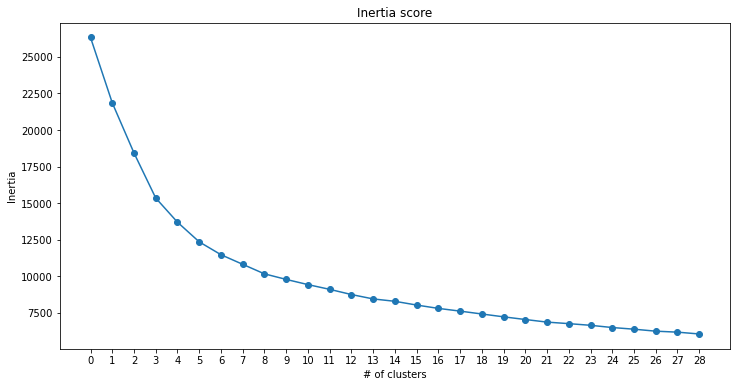

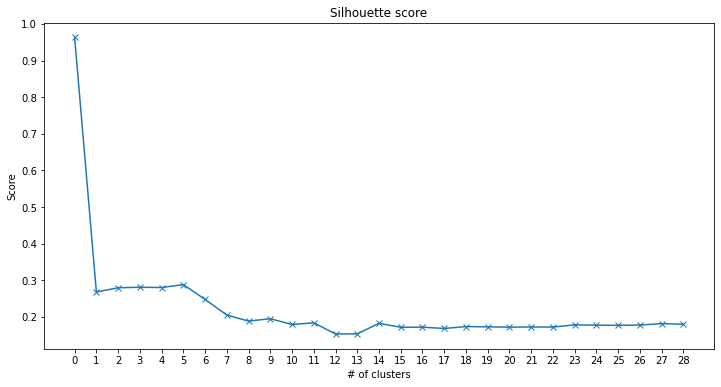

In [24]:
#kmeans with complete data
run_kmeans(complete_data, 2, 30)

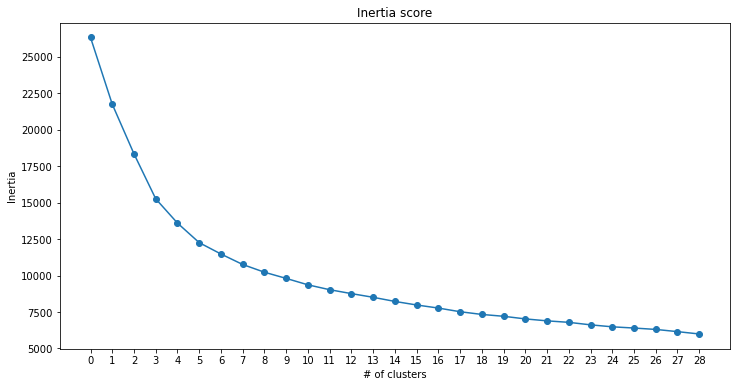

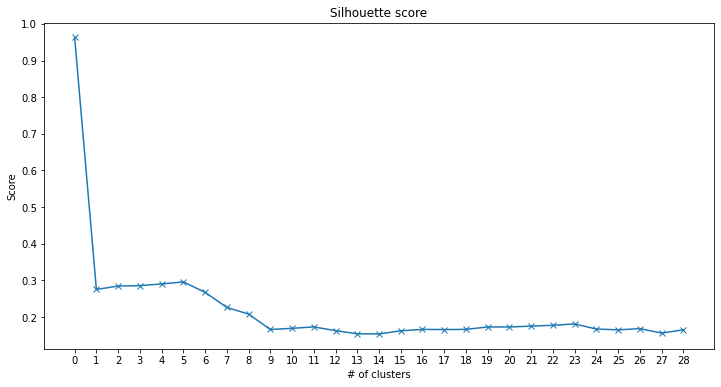

In [25]:
#kmeans with zscore data
run_kmeans(complete_zscore_data, 2, 30)

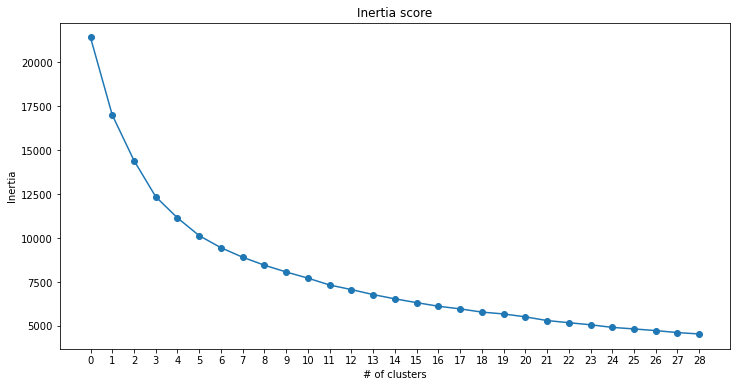

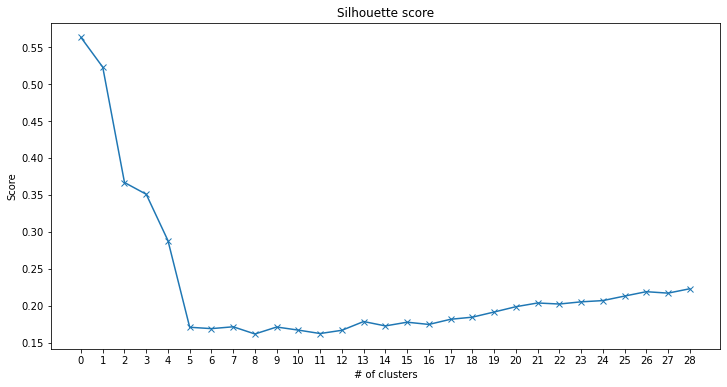

In [26]:
#kmeans with daily_moves data
run_kmeans(complete_daily_moves, 2, 30)

<p>According to inertia and average silhouette score, the number of clusters is between 5 and 7 depending on the dataset.</p>
<p>Lower inertia is seen with the daily_moves dataset. Under this dataset the number of clusters is 5.</p>
<br>
<p>We will use the data from daily_moves with 5 clusters to run a kmeans model to see how clusters behave over time compared to the price of bitcoin</p>

In [27]:
#kmeans model with k=5 using daily_moves data.
model = KMeans(n_clusters = 5, random_state=123)
model.fit_predict(complete_daily_moves)
model_labels = model.labels_
model_inertia = model.inertia_
model_silhouette = silhouette_score(complete_daily_moves, model_labels)

print(int(model_inertia), model_silhouette)

12352 0.3508263186191679


In [28]:
#Array with the model's clusters
model_labels

array([3, 3, 3, ..., 3, 1, 3], dtype=int32)

In [29]:
len(model_labels)

3473

In [30]:
#Import the DataFrame containing the daily bitcoin closing price.

grouped_pct_change_df = pd.read_csv('../data/processed/grouped_pct_change_df.csv', index_col = 0)
grouped_pct_change_df = grouped_pct_change_df.iloc[2:]
grouped_pct_change_df



,open,open.1,open.2,open.3,open.4,high,high.1,high.2,high.3,high.4,...,close.2,close.3,close.4,close.5,volume,volume_%_change,volume_up_down,close_last,high_max,low_min
2011-08-20,5.9404999524765976e-05,0.0022542612347937682,0.08554319931566301,0.0,0.08554319931566301,5.9404999524765976e-05,0.0022542612347937682,0.08554319931566301,0.0,0.08554319931566301,...,0.08554319931566301,0.0,0.08554319931566301,1.0,0.08547009,NaN,0.0,11.70,11.70,11.69
2011-08-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.08547009,0.000000,0.0,11.70,11.70,11.70
2011-08-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.02863249,-66.499988,0.0,11.70,11.70,11.70
2011-08-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-100.000000,0.0,11.70,11.70,11.70
2011-08-24,-0.0073861413028412,0.15825756563634696,0.0,-4.347826086956519,4.347826086956519,-0.0073861413028412,0.15825756563634696,0.0,-4.347826086956519,4.347826086956519,...,0.0,-4.347826086956519,4.347826086956519,0.0,2.35652174,inf,1.0,10.50,11.70,10.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-16,0.0017720097300150878,0.14260296677463047,1.120294615112294,-2.0182425488180833,3.138537163930377,0.0018085752856410258,0.11293888588921887,0.5510642074518568,-0.975229632792185,1.5262938402440418,...,1.0942460927098052,-2.0045321323122534,3.0987782250220586,1.0,8376.076088139997,20.965799,1.0,49166.53,50602.53,47036.02
2021-02-17,0.004221472211535965,0.11147365074001538,0.5349065624104643,-0.6967066225956775,1.2316131850061418,0.004136301525840744,0.0974360507003063,0.4715957087799705,-0.43399863307207465,0.9055943418520451,...,0.49747850016055306,-0.6150441446829524,1.1125226448435055,1.0,9571.647968739991,14.273651,1.0,52174.28,52640.00,48896.19
2021-02-18,-0.0007173982340404524,0.08278861253793493,0.5936371209383839,-0.369362055341782,0.962999176280166,-0.0007024025505097953,0.07304103800939805,0.6069977486056644,-0.37116730248822893,0.9781650510938933,...,0.5318124140496705,-0.40774423829568196,0.9395566523453525,0.0,6330.142918779994,-33.865694,0.0,51579.54,52566.98,50869.61
2021-02-19,0.005674708943005346,0.1071429147838894,0.548698617633292,-0.7442494078008899,1.2929480254341819,0.005673649702222628,0.09445696300561589,0.5760543751648362,-0.6079540882891976,1.1840084634540338,...,0.5995450066432761,-0.7203420312631437,1.3198870379064198,1.0,9229.782504149996,45.806858,1.0,55988.58,56399.99,50627.32


In [31]:
#We build a DataFrame with the daily bitcoin price and the cluster labels.
label_price_df = pd.DataFrame()
label_price_df['close_last'] = grouped_pct_change_df['close_last']
label_price_df['cluster_#'] = model_labels
#label_price_df.index = grouped_pct_change_df.index

label_price_df.head()

,close_last,cluster_#
2011-08-20,11.7,3
2011-08-21,11.7,3
2011-08-22,11.7,3
2011-08-23,11.7,3
2011-08-24,10.5,0


In [32]:
len(label_price_df)

3473

In [33]:
label_price_df['cluster_#'].value_counts()

3    2714
1     371
0     368
4      19
2       1
Name: cluster_#, dtype: int64

<h3>Charts showing the price of bitcoin with clusters over time</h3>
<p>We made charts of the price of bitcoin over time  but overlapping the cluster number corresponding to any given day.</p>


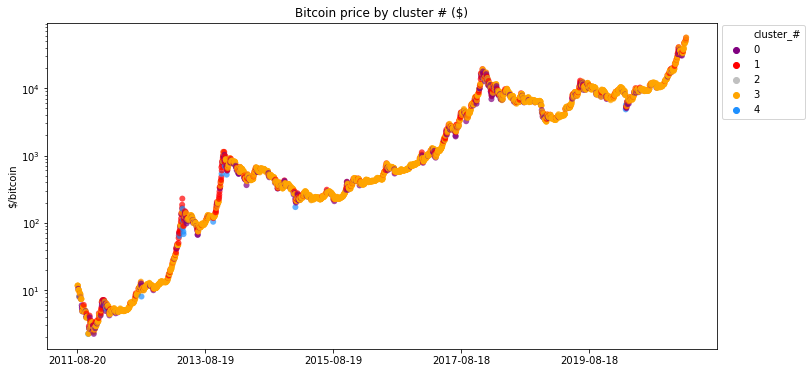

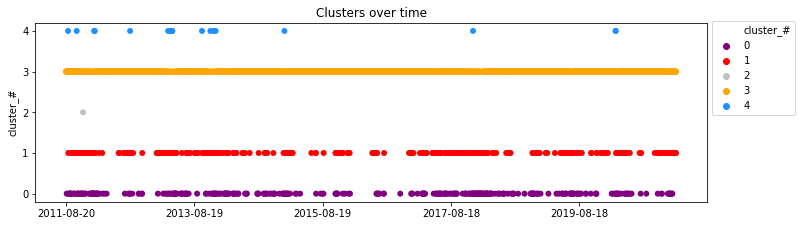

In [34]:
#Bitcoin price chart using clusters.

color_dict = dict({0:'purple',
                   1:'red',
                   2: '#C0C0C0',
                   3: 'orange',
                   4: 'dodgerblue'})

plt.figure(figsize=(12,6))
plt.title('Bitcoin price by cluster # ($)')
sns.scatterplot(x=label_price_df.index, y='close_last', data=label_price_df, hue='cluster_#', 
                alpha= 0.7, palette=color_dict,linewidth=.01)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.85), ncol=1)
plt.xticks(np.arange(0, len(label_price_df['close_last'] + 1), 365*2))
plt.ylabel('$/bitcoin')
plt.yscale('log')
plt.show()

plt.figure(figsize=(11, 3), tight_layout={'pad': 0.2})
plt.title('Clusters over time')
sns.scatterplot(x=label_price_df.index, y='cluster_#', data=label_price_df, hue='cluster_#', 
                palette=color_dict, linewidth=0)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.75), ncol=1)
plt.xticks(np.arange(0, len(label_price_df['cluster_#'] + 1), 365*2))
#plt.yticks(np.arange(0,5))
#plt.yscale('log')
plt.show()

In [35]:
#Cluster #2 has only one day.
label_price_df[label_price_df['cluster_#'] == 2]

,close_last,cluster_#
2011-11-25,2.75,2


In [36]:
#Cluster #4. 
#This cluster includes days 2020-03-12 and 2020-03-13, the two days of big market sell-off 
#related to the COVID-19 pandemic.

label_price_df[label_price_df['cluster_#'] == 4]

,close_last,cluster_#
2011-09-01,8.22,4
2011-10-20,2.24,4
2012-01-27,5.88,4
2012-01-31,5.30,4
2012-08-19,8.06,4
2013-03-23,63.90,4
2013-04-10,162.00,4
2013-04-11,83.40,4
2013-04-12,109.90,4
2013-04-15,74.00,4


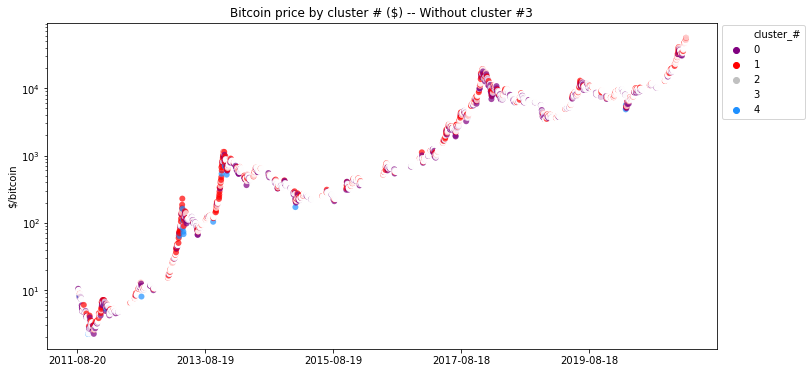

In [37]:
#Bitcoin price chart using clusters.
#Cluster #3, the most common, was taken out of the chart.

color_dict_3 = dict({0:'purple',
                   1:'red',
                   2: '#C0C0C0',
                   3: 'white',
                   4: 'dodgerblue'})

plt.figure(figsize=(12,6))
plt.title('Bitcoin price by cluster # ($) -- Without cluster #3')
sns.scatterplot(x=label_price_df.index, y='close_last', data=label_price_df, hue='cluster_#', 
                alpha= 0.7, palette=color_dict_3,linewidth=0)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.85), ncol=1)
plt.xticks(np.arange(0, len(label_price_df['close_last'] + 1), 365*2))
plt.ylabel('$/bitcoin')
plt.yscale('log')
plt.show()

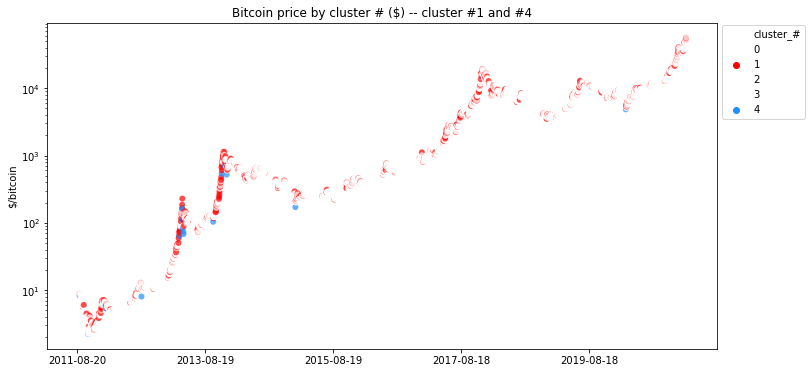

In [38]:
#Bitcoin price chart using clusters.
#Only showing clusters 1 and 4 (price tops and bottoms).

color_dict_023 = dict({0:'#FFFFFF00',
                   1:'red',
                   2: '#FFFFFF00',
                   3: '#FFFFFF00',
                   4: 'dodgerblue'})

plt.figure(figsize=(12,6))
plt.title('Bitcoin price by cluster # ($) -- cluster #1 and #4')
sns.scatterplot(x=label_price_df.index, y='close_last', data=label_price_df, hue='cluster_#', 
                alpha= 0.7, palette=color_dict_023, linewidth=0)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.85), ncol=1)
plt.xticks(np.arange(0, len(label_price_df['close_last'] + 1), 365*2))
plt.yscale('log')
plt.ylabel('$/bitcoin')
plt.show()

<h2>Extracting clusters' features</h2>
<p>For each cluster we will extract their features/statistics to see what kind of characteristics define each of them</p>

In [39]:
#Include the cluster labels in the complete_daily_moves DataFrame
complete_daily_moves['cluster_#'] = label_price_df['cluster_#']
complete_daily_moves.head()

,open-close,open-max,open-min,min-close,min-max,max-close,mfi_below_20,mfi_between_2080,roc_above_0_increasing,roc_below_0_decreasing,roc_below_0_increasing,stochastic_below_20,stochastic_between_2080,rsi_below_30,rsi_between_3070,macd_above_0_increasing,macd_below_0_decreasing,macd_below_0_increasing,cluster_#
date,,,,,,,,,,,,,,,,,,,
2011-08-20,-0.056382,-0.366572,0.659096,-0.648304,-0.513038,0.662026,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,3
2011-08-21,-0.073972,-0.377487,0.659096,-0.664426,-0.519957,0.662026,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,3
2011-08-22,-0.073972,-0.377487,0.659096,-0.664426,-0.519957,0.662026,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,3
2011-08-23,-0.073972,-0.377487,0.659096,-0.664426,-0.519957,0.662026,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,3
2011-08-24,-2.182954,-0.377487,-1.637768,-0.664426,0.404417,-2.146314,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0


In [40]:
#Group and aggregate DataFrame by cluster
groupedby_cluster_df = complete_daily_moves.groupby('cluster_#')\
                                    .agg({'open-close': 'mean', 'open-max': 'mean', 'open-min': 'mean',
                                          'min-close': 'mean', 'min-max': 'mean', 'max-close': 'mean',
                                          'mfi_below_20': 'sum', 'mfi_between_2080': 'sum', 'roc_above_0_increasing': 'sum',
                                          'roc_below_0_decreasing': 'sum', 'roc_below_0_increasing': 'sum',
                                          'stochastic_below_20': 'sum', 'stochastic_between_2080': 'sum',
                                          'rsi_below_30': 'sum', 'rsi_between_3070': 'sum', 'macd_above_0_increasing': 'sum',
                                          'macd_below_0_decreasing': 'sum', 'macd_below_0_increasing': 'sum'})

groupedby_cluster_df.head()

,open-close,open-max,open-min,min-close,min-max,max-close,mfi_below_20,mfi_between_2080,roc_above_0_increasing,roc_below_0_decreasing,roc_below_0_increasing,stochastic_below_20,stochastic_between_2080,rsi_below_30,rsi_between_3070,macd_above_0_increasing,macd_below_0_decreasing,macd_below_0_increasing
cluster_#,,,,,,,,,,,,,,,,,,
0,-1.433606,-0.095789,-1.727270,0.220108,0.670055,-1.685126,20.0,343.0,14.0,175.0,20.0,107.0,230.0,45.0,310.0,81.0,139.0,51.0
1,1.696029,1.006439,0.257243,1.343334,0.526917,0.122403,1.0,318.0,268.0,9.0,84.0,24.0,142.0,7.0,292.0,192.0,64.0,55.0
2,-1.787520,50.662543,-3.073307,1.220154,39.921400,-21.699386,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,-0.014672,-0.147433,0.254769,-0.260992,-0.221068,0.256126,21.0,2566.0,830.0,585.0,549.0,294.0,1651.0,99.0,2326.0,891.0,553.0,589.0
4,-3.160615,0.596413,-7.798442,6.722920,6.210098,-5.195399,0.0,19.0,2.0,7.0,1.0,8.0,11.0,5.0,13.0,3.0,8.0,0.0


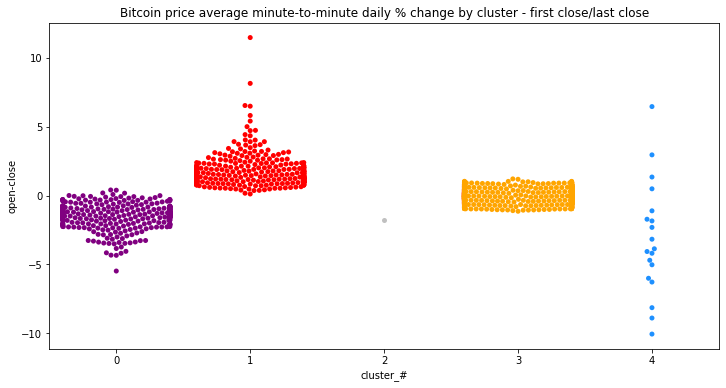

In [41]:
#Plot of average daily open-close price % change by cluster.
#Price change of days in cluster #1 are always positive and tend to have bigger increases.
#Days in cluster #3 are the "normal" days, low variability, most common cluster.
#Days in clusters #0 and #4 have greater price variability (#4 being the most extreme).

plt.figure(figsize=(12,6))
plt.title('Bitcoin price average minute-to-minute daily % change by cluster - first close/last close')
sns.swarmplot(x='cluster_#', y='open-close', data=complete_daily_moves, palette=color_dict)
plt.show()

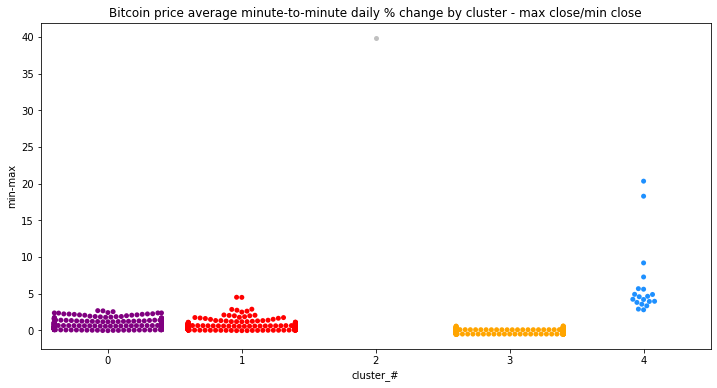

In [42]:
#Plot of average daily min-max price % change by cluster.
plt.figure(figsize=(12,6))
plt.title('Bitcoin price average minute-to-minute daily % change by cluster - max close/min close')
sns.swarmplot(x='cluster_#', y='min-max', data=complete_daily_moves, palette=color_dict)
plt.show()

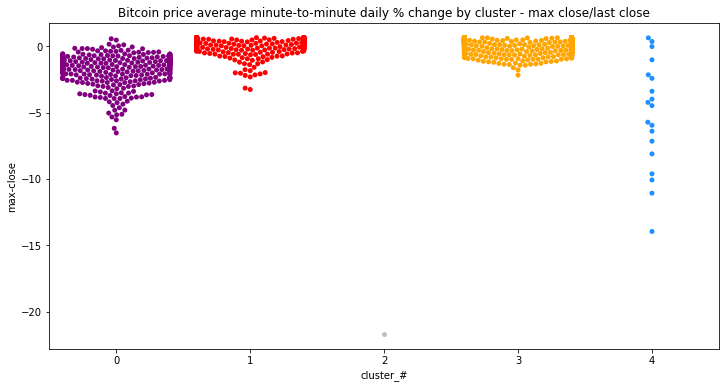

In [43]:
#Plot of average daily max-close price % change by cluster
plt.figure(figsize=(12,6))
plt.title('Bitcoin price average minute-to-minute daily % change by cluster - max close/last close')
sns.swarmplot(x='cluster_#', y='max-close', data=complete_daily_moves, palette=color_dict)
plt.show()

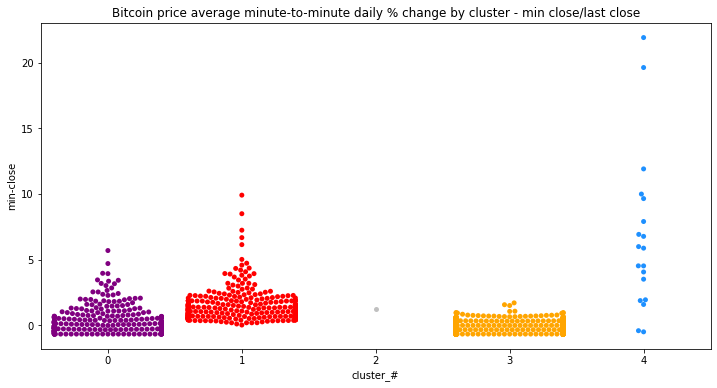

In [44]:
#Plot of average daily min-close price % change by cluster
plt.figure(figsize=(12,6))
plt.title('Bitcoin price average minute-to-minute daily % change by cluster - min close/last close')
sns.swarmplot(x='cluster_#', y='min-close', data=complete_daily_moves, palette=color_dict)
plt.show()

<h3>Charts showing the price of bitcoin with clusters over time; price history is divided by epoch corresponding to bitcoin's halving periods.</h3>
<p>We made charts of the price of bitcoin over time overlapping the cluster number corresponding to any given day and by each halving epoch (when bitcoin supply issuance halves, aproximatelly every 4 years).</p>

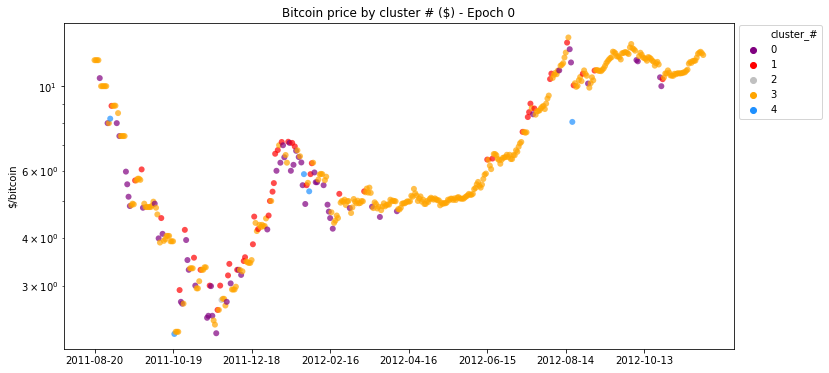

In [45]:
#Epoch 0, 2011-08-20 to 2012-11-27.
plt.figure(figsize=(12,6))
plt.title('Bitcoin price by cluster # ($) - Epoch 0')
sns.scatterplot(x=label_price_df.loc[:'2012-11-27'].index,
                y=label_price_df['close_last'].loc[:'2012-11-27'],
                data=label_price_df.loc[:'2012-11-27'], 
                hue='cluster_#', alpha= 0.7, palette=color_dict, linewidth=.01)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.85), ncol=1)
plt.xticks(np.arange(0, len(label_price_df['close_last'].loc[:'2012-11-27'] + 1), 30*2))
plt.yscale('log')
plt.ylabel('$/bitcoin')
plt.show()




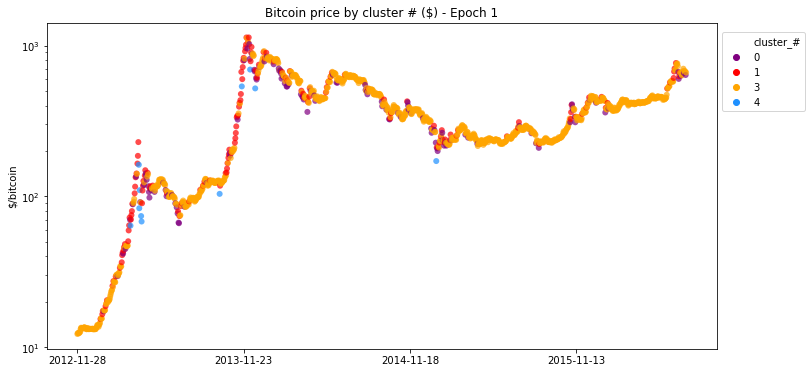

In [46]:
#Epoch 1, 2012-11-28 to 2016-07-08.
plt.figure(figsize=(12,6))
plt.title('Bitcoin price by cluster # ($) - Epoch 1')
sns.scatterplot(x=label_price_df.loc['2012-11-28':'2016-07-08'].index,
                y=label_price_df['close_last'].loc['2012-11-28':'2016-07-08'],
                data=label_price_df.loc['2012-11-28':'2016-07-08'], 
                hue='cluster_#', alpha= 0.7, palette=color_dict,linewidth=.01)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.85), ncol=1)
plt.xticks(np.arange(0, len(label_price_df['close_last'].loc['2012-11-28':'2016-07-08'] + 1), 180*2))
plt.yscale('log')
plt.ylabel('$/bitcoin')
plt.show()

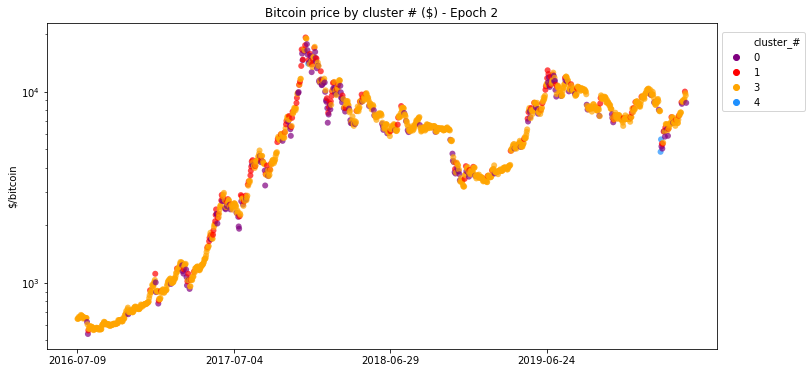

In [47]:
#Epoch 2, 2016-07-09 to 2020-05-10.
plt.figure(figsize=(12,6))
plt.title('Bitcoin price by cluster # ($) - Epoch 2')
sns.scatterplot(x=label_price_df.loc['2016-07-09':'2020-05-10'].index,
                y=label_price_df['close_last'].loc['2016-07-09':'2020-05-10'],
                data=label_price_df.loc['2016-07-09':'2020-05-10'], 
                hue='cluster_#', alpha= 0.7, palette=color_dict,linewidth=.01)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.85), ncol=1)
plt.xticks(np.arange(0, len(label_price_df['close_last'].loc['2016-07-09':'2020-05-10'] + 1), 180*2))
plt.yscale('log')
plt.ylabel('$/bitcoin')
plt.show()

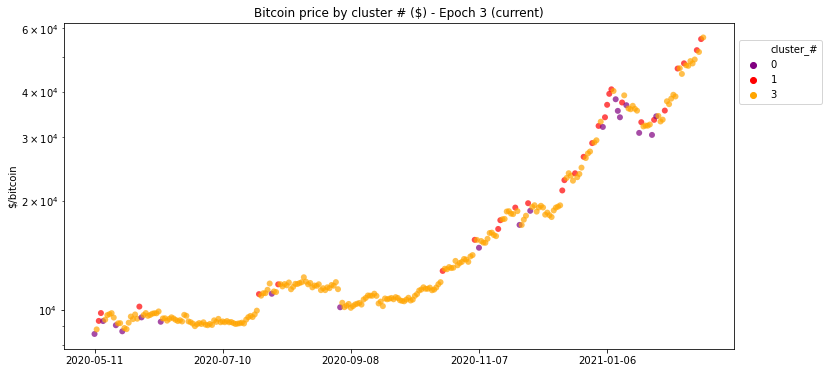

In [48]:
#Epoch 3 (current epoch), 2020-05-11 -->.
plt.figure(figsize=(12,6))
plt.title('Bitcoin price by cluster # ($) - Epoch 3 (current)')
sns.scatterplot(x=label_price_df.loc['2020-05-11':].index,
                y=label_price_df['close_last'].loc['2020-05-11':],
                data=label_price_df.loc['2020-05-11':], 
                hue='cluster_#', alpha= 0.7, palette=color_dict,linewidth=.01)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.85), ncol=1)
plt.xticks(np.arange(0, len(label_price_df['close_last'].loc['2020-05-11':] + 1), 30*2))
plt.yscale('log')
plt.ylabel('$/bitcoin')
plt.show()

<h2>Conclusions</h2>

<p>We were able to group the daily bitcoin price behavior into clusters using a classification algorithm</p>
<p>Under our classification model, the optimal number of clusters was 5.</p>

<ul>Regarding the clusters, the most important findings were:<ul>
    <li>The majority of the days correspond to cluster #3. Days in this cluster could be thought as the "normal days", where the price of bitcoin has low variability, and as it corresponds to the most common cluster.</li>
    <li>Cluster #1 shows at times when the bitcoin price has increased sharply (during, and, or at the end of bull cycles).</li>
    <li>Days in clusters #0 and #4 are typically seen after a correction in prices and/or at the end of bear cycles. Cluster #4 is less common and seems to show only after sharp corrections and/or to signal the market bottom. Of course, there are also false positives. Cluster #4 includes days 2020-03-12 and 2020-03-13, the two days of the big market sell-off related to the COVID-19 pandemic.</li>
    <li>Cluster #2 has only one day (2011-11-25) which must be seen as an outlier. In this day, there was a sharp intraday increase (open to high) and then a reversal (big move from high to low).</li>